## Import & PreProcess

In [1]:
# --- tiny helpers for asymmetric × combination ---
import numpy as np
import pandas as pd

def _rel_band(c, lo, hi):
    c = np.asarray(c, float)
    lo = np.asarray(lo, float)
    hi = np.asarray(hi, float)
    # guard against division by zero
    eps = 1e-14
    rel_plus  = np.where(np.abs(c) > eps, (hi - c)/c, 0.0)
    rel_minus = np.where(np.abs(c) > eps, (c - lo)/c, 0.0)
    return rel_minus, rel_plus  # (- , +)

def combine_product_asym(Ac, Alo, Ahi, Bc, Blo, Bhi):
    """
    Multiply two quantities with asymmetric bands, add relative errors in quadrature.
    Returns central, lo, hi arrays.
    """
    Ac = np.asarray(Ac, float); Alo = np.asarray(Alo, float); Ahi = np.asarray(Ahi, float)
    Bc = np.asarray(Bc, float); Blo = np.asarray(Blo, float); Bhi = np.asarray(Bhi, float)

    Arelm, Arelp = _rel_band(Ac, Alo, Ahi)
    Brelm, Brelp = _rel_band(Bc, Blo, Bhi)

    Cc = Ac * Bc
    Crelp = np.sqrt(Arelp**2 + Brelp**2)
    Crelm = np.sqrt(Arelm**2 + Brelm**2)

    Chi = Cc * (1.0 + Crelp)
    Clo = Cc * (1.0 - Crelm)
    return Cc, Clo, Chi

def avg_band_by_weights(x_c, x_lo, x_hi, w):
    """
    Average a band-valued quantity over a bin (e.g., several b's inside a centrality)
    using weights w (≥0). Do this by averaging central and the +/- deviations separately.
    """
    x_c  = np.asarray(x_c,  float); w = np.asarray(w, float)
    x_lo = np.asarray(x_lo, float); x_hi = np.asarray(x_hi, float)
    s = w.sum()
    if s <= 0:  # nothing to average
        return (np.nan, np.nan, np.nan)
    cbar  = float(np.sum(w * x_c ) / s)
    d_lo  = x_c - x_lo
    d_hi  = x_hi - x_c
    dlo   = float(np.sum(w * d_lo) / s)
    dhi   = float(np.sum(w * d_hi) / s)
    return cbar, cbar - dlo, cbar + dhi

In [2]:
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# point Python at the ./code folder
project = Path.cwd()
sys.path.insert(0, str(project / "code"))

# === eloss ===
from eloss_module import ELossRun, load_eloss_run
# (You already use load_eloss_run; ELossRun is the underlying class.)
# :contentReference[oaicite:3]{index=3}

# === nPDF (CNM part 1) ===
from npdf_module import (
    NPDFSystem, RpAAnalysis,
    WoodsSaxonPb, CentralityModel, GluonFromGrid, GluonRatioTable,
    step_band_xy, band_xy, style_axes
)
# :contentReference[oaicite:4]{index=4}

# === primordial (HNM) ===
from primordial_module import (
    ReaderConfig, build_ensemble, make_bins_from_width
)
# :contentReference[oaicite:5]{index=5}

In [3]:
# ---- ELoss (your existing base path, JPsi only) ----
BASE_Eloss5eV = "/home/sawin/Desktop/Charmonia/combined_data_analysis/input/eloss/pPb5TeV"
BASE_Eloss8eV = "/home/sawin/Desktop/Charmonia/combined_data_analysis/input/eloss/pPb8TeV"

eloss_run5TeV = load_eloss_run(BASE_Eloss5eV)
eloss_run8TeV = load_eloss_run(BASE_Eloss8eV)

# ---- nPDF: build RpA grid & centrality model (5.02 TeV) ----
ana = RpAAnalysis()
sys5 = NPDFSystem.from_folder("./input/npdf/pPb5TeV", kick="pp", name="p+Pb 5.02 TeV")
rgrid5 = ana.compute_rpa_grid(sys5.df_pp, sys5.df_pa, sys5.df_errors, join="intersect")

# Gluon ratio provider (use your table if present, else grid fallback)
try:
    SA5 = GluonRatioTable(Path("./input/gluon_ratio/5TeV").glob("*.tsv").__iter__().__next__(), sqrt_sNN_GeV=5020.0).load()
except StopIteration:
    SA5 = GluonFromGrid(sys5.df_pp, sys5.df_pa)

geom = WoodsSaxonPb()
model5 = CentralityModel.from_inputs(SA5, geom, b_max=12.0, nb=601)
sigmaNN_mb5 = 67.0

# Choose centrality edges that match ELoss (0-20,20-40,40-60,60-100)
cent_edges_4 = [0,20,40,60,100]

# Physics windows to reuse
Y_WINDOWS = [(-1.93,1.93), (1.5,4.0), (-5.0,-2.5)]   # mid / fwd / bwd
PT_RANGE_FULL = (0.1, 20.0)

[INFO] Loaded 0-20
[INFO] Loaded 20-40
[INFO] Loaded 40-60
[INFO] Loaded 60-100
[INFO] Loaded 0-20
[INFO] Loaded 20-40
[INFO] Loaded 40-60
[INFO] Loaded 60-100


# $R_{pA}$ vs Centrality

In [4]:
## CNM = nPDF x Eloss
def cnm_vs_centrality(model, rgrid, pa_df, cent_edges, y_range, pt_range, sigmaNN_mb):
    # nPDF band (integrated to the same centrality bins)
    tab_np = model.rpa_vs_centrality_integrated(
        rgrid, pa_df, cent_edges,
        y_min=y_range[0], y_max=y_range[1],
        pt_min=pt_range[0], pt_max=pt_range[1],
        sigmaNN_mb=sigmaNN_mb, weight="inelastic", verbose=False
    ).copy()

    # eloss value in the same bins (no band)
    rows = []
    for label in tab_np["cent_bin"]:
        rows.append({
            "cent_bin": label,
            "eloss": eloss_run.mean_rpa_over_y_and_pt(label.replace("%",""), y_range, pt_range)
        })
    tab_el = pd.DataFrame(rows)

    # merge and multiply with asymmetric propagation
    out = tab_np.merge(tab_el, on="cent_bin", how="inner")
    Cc, Clo, Chi = combine_product_asym(
        out["r_central"].to_numpy(), out["r_lo"].to_numpy(), out["r_hi"].to_numpy(),
        out["eloss"].to_numpy(),   out["eloss"].to_numpy(), out["eloss"].to_numpy()  # exact (no spread)
    )
    out["cnm_c"] = Cc; out["cnm_lo"] = Clo; out["cnm_hi"] = Chi
    return out[["cent_bin","r_central","r_lo","r_hi","eloss","cnm_c","cnm_lo","cnm_hi"]]


In [5]:
cnm_tabs = {nm: cnm_vs_centrality(model5, rgrid5, sys5.df_pa, cent_edges_4, ywin, PT_RANGE_FULL, sigmaNN_mb5)
            for nm,ywin in zip(["mid","fwd","bwd"], Y_WINDOWS)}

NameError: name 'eloss_run' is not defined

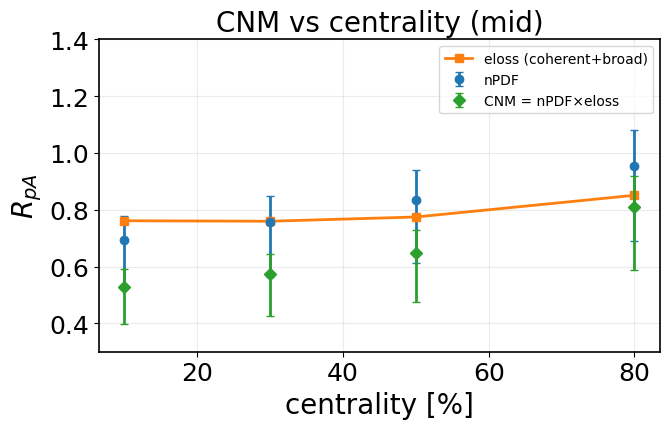

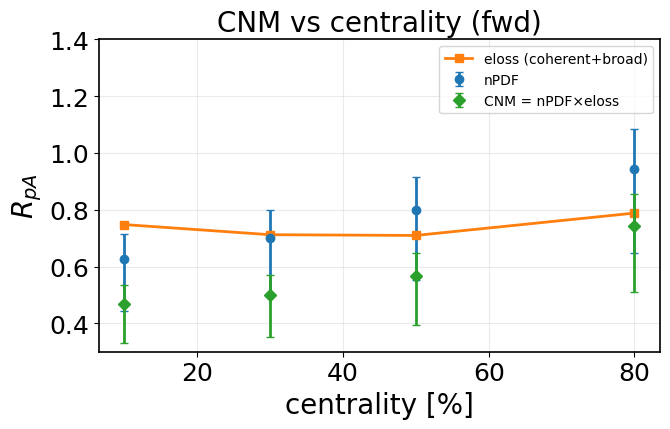

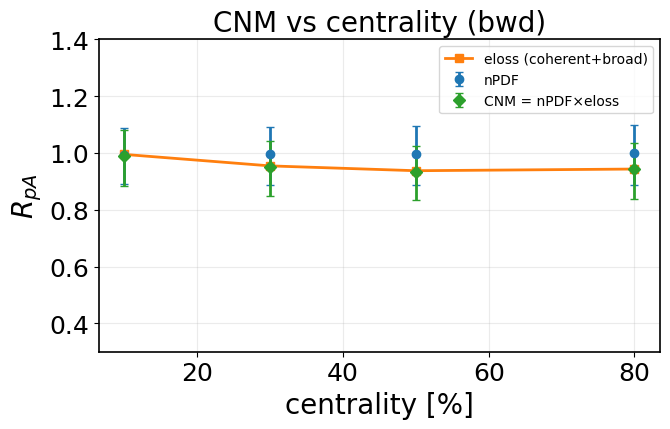

In [ ]:
## Primordial vs CNM 
for nm,tab in cnm_tabs.items():
    fig, ax = plt.subplots()
    # nPDF band
    x = 0.5*np.array([float(s.split('-')[0]) + float(s.split('-')[1].rstrip('%')) for s in tab["cent_bin"]])
    y, ylo, yhi = tab["r_central"].to_numpy(), tab["r_lo"].to_numpy(), tab["r_hi"].to_numpy()
    ax.errorbar(x, y, yerr=np.vstack([y - ylo, yhi - y]), fmt="o", capsize=3, label="nPDF")

    # eloss points
    ax.plot(x, tab["eloss"], "s-", label="eloss (coherent+broad)")

    # CNM band
    ax.errorbar(x, tab["cnm_c"], yerr=np.vstack([tab["cnm_c"]-tab["cnm_lo"], tab["cnm_hi"]-tab["cnm_c"]]),
                fmt="D", capsize=3, label="CNM = nPDF×eloss")
    style_axes(ax, "centrality [%]", r"$R_{pA}$", title=f"CNM vs centrality ({nm})")
    ax.set_ylim(0.3, 1.4); ax.legend()
    plt.show()

# $R_{pA}$ vs Rapidity

In [ ]:
# -- Load primordial ensemble (same as your notebook) --
base_prefix     = str(project / "input" / "primordial" / "pPb5TeV" / "output_5pPb_Tf170_NPWLC")
centrality_root = str(project / "input" / "glauber_data" / "5TeV")
ens, runs = build_ensemble(base_prefix, centrality_root, tags=("tau1","tau2"))

# Primordial: R_HNM(y) per-b (with feed-down ON, flip y ON)
y_bins = make_bins_from_width(-5, 5, 0.5)
ryb_center, ryb_band = ens.central_and_band_vs_y_per_b(
    pt_window=(0.0, 20.0), y_bins=y_bins,
    with_feeddown=True, use_nbin=True, flip_y=True
)

# Model centrality table to map % bins to b-intervals
ctab = model5.centrality_table(cent_edges_4, sigmaNN_mb=sigmaNN_mb5)

def _b_interval_for_cent(label):
    # label like "0-20%"; we look up min/max b by percentiles from the table
    row = ctab[ctab["cent_bin"]==label].iloc[0]
    return float(row["b_left"]), float(row["b_right"])

def primordial_Ry_by_cent(ryb_center, ryb_band, state="jpsi_1S"):
    """
    Average primordial R_HNM(y) over the b-range of each centrality bin.
    Returns dict: label -> DataFrame with columns [y, c, lo, hi]
    """
    out = {}
    # DataFrames keyed by b & y with columns: state and state_err (center/band holders)
    C = ryb_center[["b","y",state]].rename(columns={state:"c"}).copy()
    # Construct symmetric-ish bounds from center±err if needed
    # (ryb_band is a 2D table of min/max envelope; you may have columns like f"{state}_lo"/"_hi")
    # If ryb_band already has lo/hi columns, use them directly; if not, fall back to ±err.
    cols = [f"{state}_lo", f"{state}_hi"]
    if all(col in ryb_band.columns for col in cols):
        B = ryb_band[["b","y"]+cols].rename(columns={cols[0]:"lo", cols[1]:"hi"}).copy()
    else:
        err_col = f"{state}_err"
        B = ryb_center[["b","y",state,err_col]].copy()
        B["lo"] = B[state] - B[err_col]
        B["hi"] = B[state] + B[err_col]
        B = B[["b","y","lo","hi"]]
    M = C.merge(B, on=["b","y"], how="inner")

    for label in ctab["cent_bin"]:
        bL,bR = _b_interval_for_cent(label)
        sub = M[(M["b"]>=bL)&(M["b"]<=bR)].copy()
        if sub.empty: 
            out[label] = pd.DataFrame(columns=["y","c","lo","hi"]); continue
        # average over b at each y (flat weights across b)
        rows=[]
        for yv,g in sub.groupby("y", sort=True):
            c, lo, hi = avg_band_by_weights(g["c"].to_numpy(), g["lo"].to_numpy(), g["hi"].to_numpy(),
                                            np.ones(len(g)))
            rows.append(dict(y=float(yv), c=c, lo=lo, hi=hi))
        out[label] = pd.DataFrame(rows).sort_values("y").reset_index(drop=True)
    return out

prim_y_1S = primordial_Ry_by_cent(ryb_center, ryb_band, state="jpsi_1S")
prim_y_2S = primordial_Ry_by_cent(ryb_center, ryb_band, state="psi_2S")
prim_y_1P = primordial_Ry_by_cent(ryb_center, ryb_band, state="chicJ_1P")


[INFO] Loaded 1,310,000 events from '/home/sawin/Desktop/Charmonia/combined_data_analysis/input/primordial/pPb5TeV/output_5pPb_Tf170_NPWLC_tau1/datafile.gz'. b∈[1.53,7.42], pT∈[0.001082,39.63], y∈[-4.77,5.84]
[INFO] Loaded 1,310,000 events from '/home/sawin/Desktop/Charmonia/combined_data_analysis/input/primordial/pPb5TeV/output_5pPb_Tf170_NPWLC_tau2/datafile.gz'. b∈[1.53,7.42], pT∈[0.001082,39.63], y∈[-4.77,5.84]
[rpa_vs_y_per_b] b=1.526 (1)
[rpa_vs_y_per_b] b=2.791 (2)
[rpa_vs_y_per_b] b=3.614 (3)
[rpa_vs_y_per_b] b=4.280 (4)
[rpa_vs_y_per_b] b=4.855 (5)
[rpa_vs_y_per_b] b=5.368 (6)
[rpa_vs_y_per_b] b=5.838 (7)
[rpa_vs_y_per_b] b=6.279 (8)
[rpa_vs_y_per_b] b=6.728 (9)
[rpa_vs_y_per_b] b=7.422 (10)
[rpa_vs_y_per_b] b=1.526 (1)
[rpa_vs_y_per_b] b=2.791 (2)
[rpa_vs_y_per_b] b=3.614 (3)
[rpa_vs_y_per_b] b=4.280 (4)
[rpa_vs_y_per_b] b=4.855 (5)
[rpa_vs_y_per_b] b=5.368 (6)
[rpa_vs_y_per_b] b=5.838 (7)
[rpa_vs_y_per_b] b=6.279 (8)
[rpa_vs_y_per_b] b=6.728 (9)
[rpa_vs_y_per_b] b=7.422 (10)


In [ ]:
# nPDF(y) by centrality (Δy=0.5, pT≥0.1–20.0)
bands_np_y = model5.rpa_vs_y_in_centrality_bins(
    rgrid5, sys5.df_pa, cent_edges_4,
    y_width=0.5, pt_min=PT_RANGE_FULL[0],
    sigmaNN_mb=sigmaNN_mb5, weight="inelastic", verbose=False
)
# Convert the list[(label, df)] to a dict: label->df
npdf_y_by_cent = {lab: df.copy() for (lab, df) in bands_np_y if not df.empty}

def eloss_y_by_cent(label, y_edges, pt_range):
    ys = 0.5*(y_edges[:-1] + y_edges[1:])
    vals = [eloss_run.mean_rpa_over_pt(label.replace("%",""), (yl, yr), pt_range) for (yl,yr) in zip(y_edges[:-1], y_edges[1:])]
    return pd.DataFrame(dict(y=ys, eloss=np.array(vals, float)))

# Build CNM(y) in each cent bin
cnm_y_by_cent = {}
for lab, dfN in npdf_y_by_cent.items():
    y_left = dfN["y_left"].to_numpy(float)
    y_edges = np.r_[y_left, y_left[-1] + (y_left[1]-y_left[0])]  # recover rightmost edge
    dfE = eloss_y_by_cent(lab, y_edges, PT_RANGE_FULL)
    # align on centers: dfN uses left-edges; build centers the same way
    y_centers = 0.5*(y_edges[:-1] + y_edges[1:])
    # interpolate eloss to these centers if needed (usually identical)
    from numpy import interp
    E = interp(y_centers, dfE["y"], dfE["eloss"])
    Cc, Clo, Chi = combine_product_asym(
        dfN["r_central"].to_numpy(), dfN["r_lo"].to_numpy(), dfN["r_hi"].to_numpy(),
        E, E, E
    )
    cnm_y_by_cent[lab] = pd.DataFrame(dict(y=y_centers, c=Cc, lo=Clo, hi=Chi))

In [ ]:
def total_y_state(prim_by_cent, cnm_by_cent):
    out = {}
    for lab, dfH in prim_by_cent.items():  # dfH: columns y, c, lo, hi
        if lab not in cnm_by_cent: 
            continue
        dfC = cnm_by_cent[lab]
        # align on y via interpolation to be safe
        y = dfH["y"].to_numpy()
        Cc  = np.interp(y, dfC["y"],  dfC["c"])
        Clo = np.interp(y, dfC["y"],  dfC["lo"])
        Chi = np.interp(y, dfC["y"],  dfC["hi"])
        Tc, Tlo, Thi = combine_product_asym(
            Cc, Clo, Chi,
            dfH["c"].to_numpy(), dfH["lo"].to_numpy(), dfH["hi"].to_numpy()
        )
        out[lab] = pd.DataFrame(dict(y=y, c=Tc, lo=Tlo, hi=Thi))
    return out

tot_y_1S = total_y_state(prim_y_1S, cnm_y_by_cent)
tot_y_2S = total_y_state(prim_y_2S, cnm_y_by_cent)
tot_y_1P = total_y_state(prim_y_1P, cnm_y_by_cent)

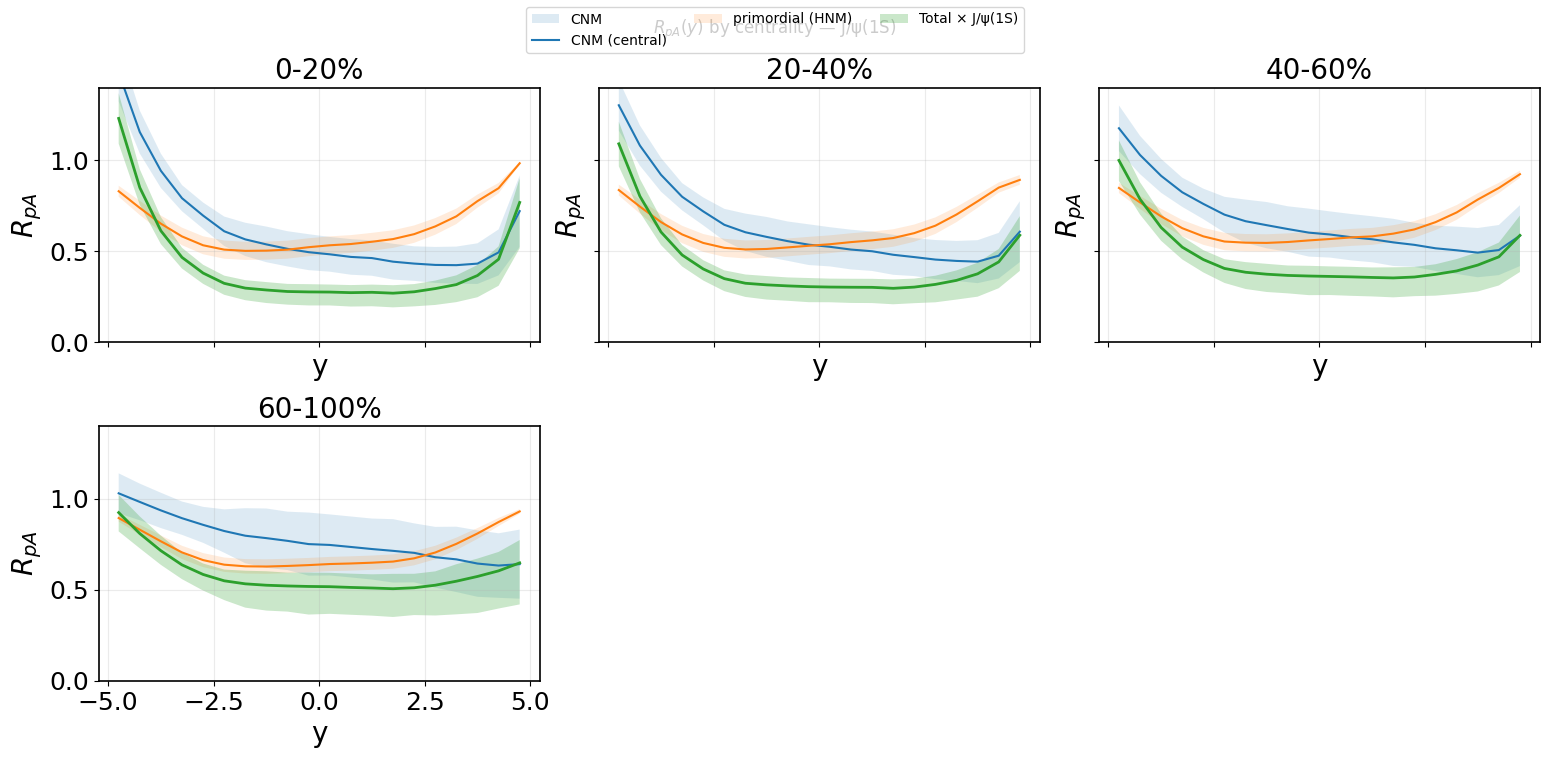

In [ ]:
def plot_y_subfigs(cnm_by_cent, prim_by_cent, total_by_cent, state_label):
    labs = list(cnm_by_cent.keys())
    n = len(labs); ncols = min(3, n); nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.2*ncols, 3.8*nrows), sharex=True, sharey=True)
    axes = np.atleast_1d(axes).ravel()
    for ax, lab in zip(axes, labs):
        dfC = cnm_by_cent[lab]; ax.fill_between(dfC["y"], dfC["lo"], dfC["hi"], alpha=0.15, label="CNM")
        # decompose CNM to show nPDF band + eloss line if you want:
        # (already included; optional extra curves for clarity)
        ax.plot(dfC["y"], 0.5*(dfC["hi"]+dfC["lo"]), lw=1.5, label="CNM (central)")

        if lab in prim_by_cent:
            dH = prim_by_cent[lab]; ax.fill_between(dH["y"], dH["lo"], dH["hi"], alpha=0.15, label="primordial (HNM)")
            ax.plot(dH["y"], dH["c"], lw=1.5)

        if lab in total_by_cent:
            dT = total_by_cent[lab]; ax.fill_between(dT["y"], dT["lo"], dT["hi"], alpha=0.25, label=f"Total × {state_label}")
            ax.plot(dT["y"], dT["c"], lw=2)

        style_axes(ax, "y", r"$R_{pA}$", title=f"{lab}")
        ax.set_ylim(0.0,1.4)
    for ax in axes[len(labs):]: ax.axis("off")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncols=3)
    fig.suptitle(f"$R_{{pA}}(y)$ by centrality — {state_label}")
    plt.show()

plot_y_subfigs(cnm_y_by_cent, prim_y_1S, tot_y_1S, "J/ψ(1S)")

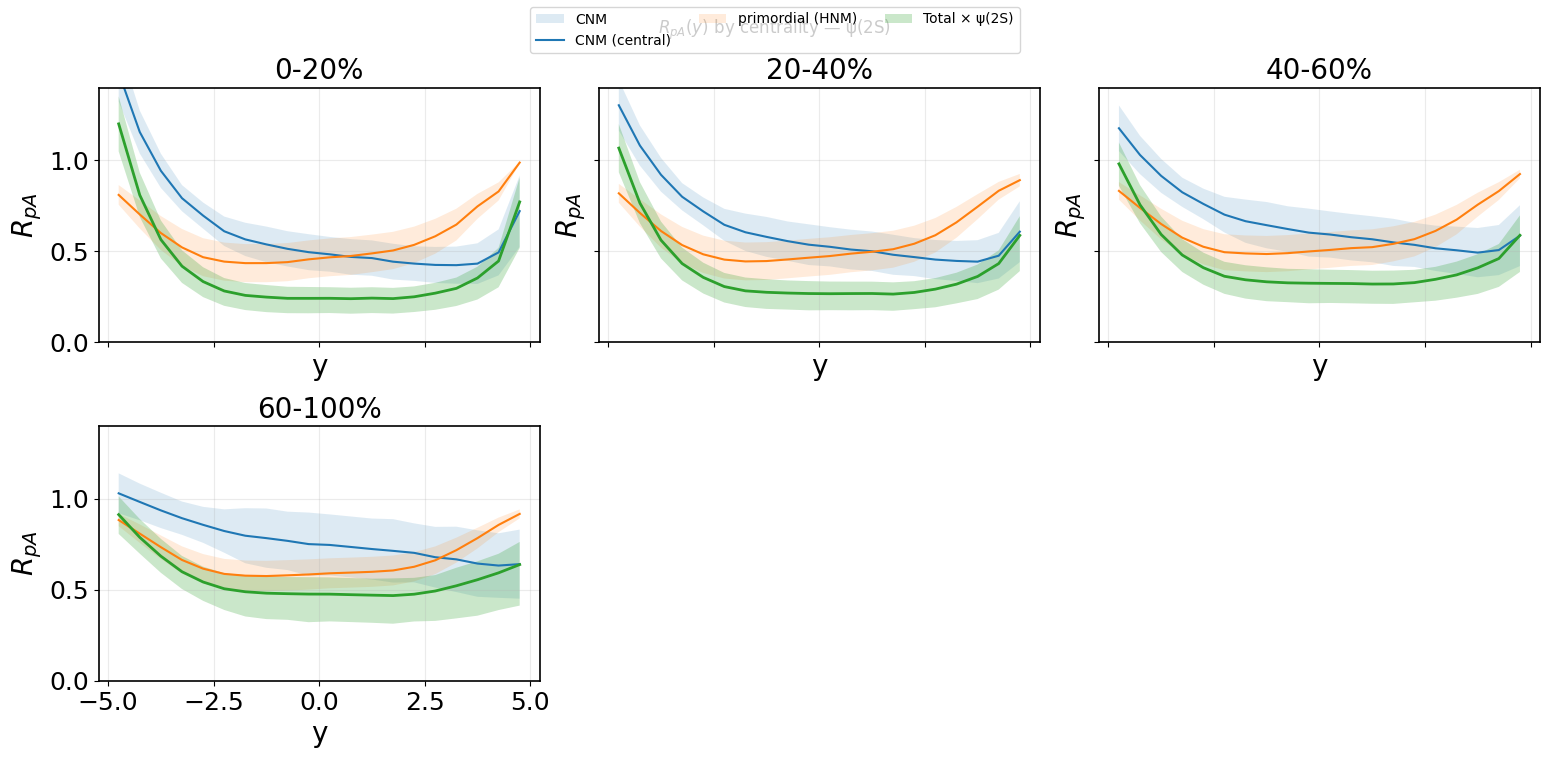

In [ ]:
plot_y_subfigs(cnm_y_by_cent, prim_y_2S, tot_y_2S, "ψ(2S)")

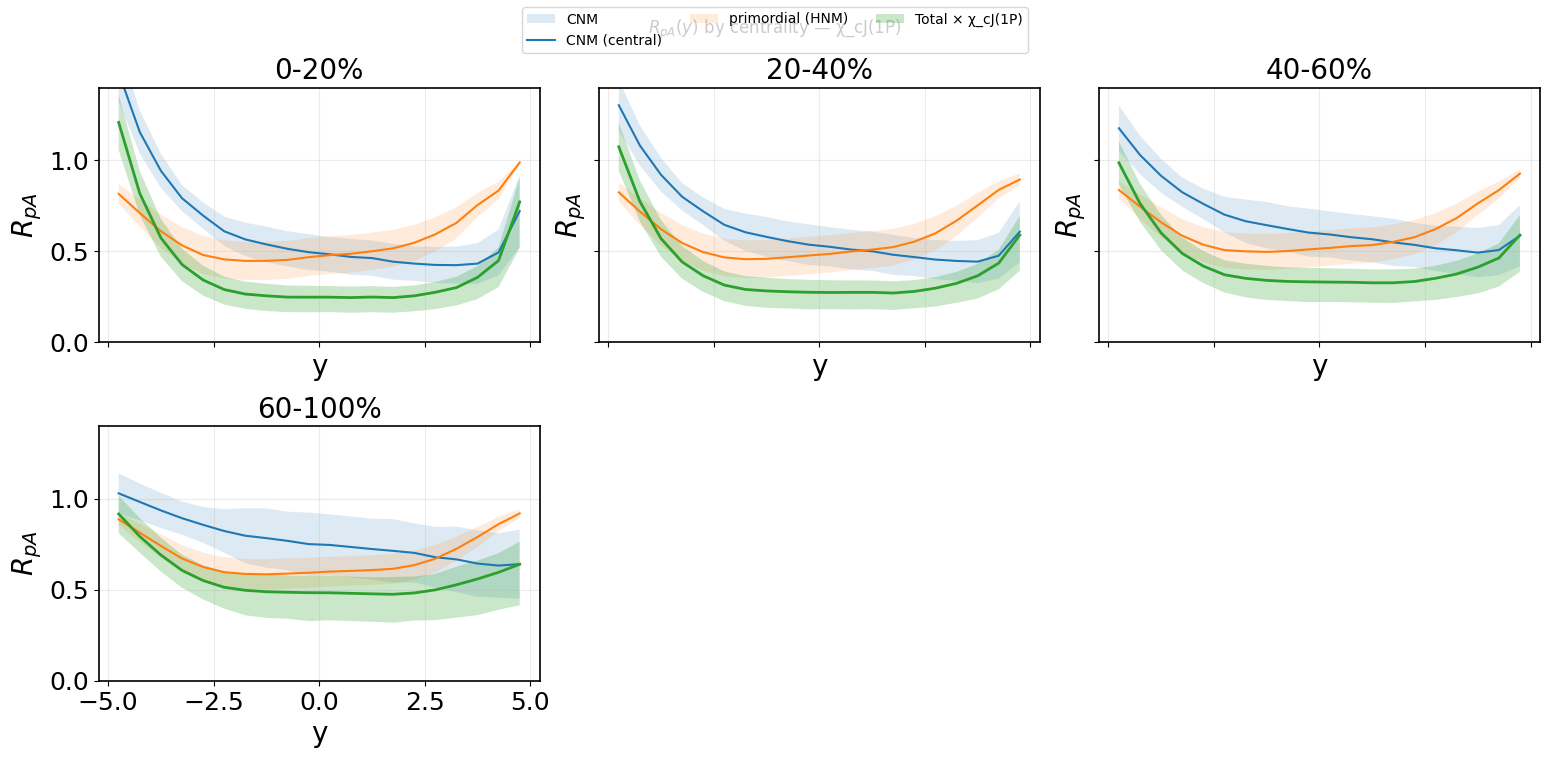

In [ ]:
plot_y_subfigs(cnm_y_by_cent, prim_y_1P, tot_y_1P, "χ_cJ(1P)")

# $R_{pA}$ vs Transverse Momentum